# Benchmark of well-mixed stochastic solvers for a gene expression model

STEPS simulation of the Gene expression model described in appendix A.6 of https://link.springer.com/978-3-319-63113-4, comparing the performance of the 'direct' and 'rssa' stochastic solvers for this model. The solvers are also tested by comparing them to a simplified version of the model with an analytic solution.

## Model

The model consists of five species, $\{G,M,P,P_2,P_2G\}$, that interact as follows:

* A gene $G$ transcribes to an intermediate product $M$ with rate $c_1$.
* $M$ translates to a protein $P$ with rate $c_2$ or degrades with rate $c_3$.
* $P$ degrades with rate $c_4$, or two proteins $P$ can form a dimer $P_2$ with rate $c_5$, or vice versa with rate $c_6$.
* Finally the dimer $P_2$ can bind to $G$ with rate $c_7$, and vice versa with rate $c_8$.

This can be written as a set of eight reactions, each with a reaction rate $c_i$:
\begin{align}
    G &{\overset{c_1}{\rightarrow}} G + M \\
    M &{\overset{c_2}{\rightarrow}} M + P \\
    M &{\overset{c_3}{\rightarrow}} \emptyset \\
    P &{\overset{c_4}{\rightarrow}} \emptyset \\
    2 P &{\overset{c_5}{\rightarrow}} P_2 \\
    P_2 &{\overset{c_6}{\rightarrow}} 2 P \\
    P_2 + G &{\overset{c_7}{\rightarrow}} P_2 G \\
    P_2 G &{\overset{c_8}{\rightarrow}} P_2 + G \\
\end{align}

The initial condition of the model is to have $1000$ genes $G$, with the values for $c_i$ as specified below.

## STEPS setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We have reaction rates $c_i$ in units of $s^{-1}$, need to convert these to units of $M^{(1-n)}s^{-1}$ for the parameter `kcst` in STEPS, where $n$ is the order of the reaction, i.e. the number of molecules on the LHS:

In [2]:
# convert stochastic reaction rate in specified volume to STEPS kcst
# order is the number of molecules on the left hand side of the reaction
def get_kcst(stoch_rate, order, volume):
    import numpy as np
    A = 6.02214076e23 # Avogadro number: molecules in 1 mol
    litres = 1e3 * volume
    return stoch_rate / np.power(A * litres, 1-order)

In [3]:
import steps.model as smodel

mdl = smodel.Model()
vsys = smodel.Volsys('vsys', mdl)

molG = smodel.Spec('G', mdl)
molM = smodel.Spec('M', mdl)
molP = smodel.Spec('P', mdl)
molP2 = smodel.Spec('P2', mdl)
molP2G = smodel.Spec('P2G', mdl)

vol = 1e-20

kreac_1 = smodel.Reac('kreac_1', vsys, lhs=[molG],        rhs=[molG, molM],  kcst=get_kcst(0.09, 1, vol))
kreac_2 = smodel.Reac('kreac_2', vsys, lhs=[molM],        rhs=[molM, molP],  kcst=get_kcst(0.05, 1, vol))
kreac_3 = smodel.Reac('kreac_3', vsys, lhs=[molM],        rhs=[],            kcst=get_kcst(0.001, 1, vol))
kreac_4 = smodel.Reac('kreac_4', vsys, lhs=[molP],        rhs=[],            kcst=get_kcst(0.0009, 1, vol))
kreac_5 = smodel.Reac('kreac_5', vsys, lhs=[molP, molP],  rhs=[molP2],       kcst=get_kcst(0.00001, 2, vol))
kreac_6 = smodel.Reac('kreac_6', vsys, lhs=[molP2],       rhs=[molP, molP],  kcst=get_kcst(0.0005, 1, vol))
kreac_7 = smodel.Reac('kreac_7', vsys, lhs=[molP2, molG], rhs=[molP2G],      kcst=get_kcst(0.005, 2, vol))
kreac_8 = smodel.Reac('kreac_8', vsys, lhs=[molP2G],      rhs=[molP2, molG], kcst=get_kcst(0.9, 1, vol))

The geometry is a single well-mixed compartment:

In [4]:
import steps.geom as swm

wmgeom = swm.Geom()
comp = swm.Comp('comp', wmgeom)
comp.addVolsys('vsys')
comp.setVol(vol)

## Simulation

In [5]:
import steps.rng as srng
rng = srng.create('mt19937', 256)

import steps.solver as ssolver
solver_direct = ssolver.Wmdirect(mdl, wmgeom, rng)
solver_rssa = ssolver.Wmrssa(mdl, wmgeom, rng)

In [8]:
def simulate(solver, n_G=1000, t_final=100, t_interval=0.2, rng_seed=123, n_replicas=100, simplified_model=False):
    mol_list = ['G', 'M', 'P', 'P2', 'P2G']
    if(simplified_model):
        mol_list = ['G', 'M', 'P']
    results = np.zeros((n_replicas, int(t_final/t_interval), int(1+len(mol_list))))
    if(solver.getSolverName() == "b'wmrk4'"):
        n_replicas = 1
    for i in range(n_replicas):
        rng.initialize(rng_seed+i)
        solver.reset()
        solver.setCompVol('comp', vol)
        solver.setCompCount('comp', 'G', n_G)
        if(simplified_model):
            solver.setCompReacK('comp', 'kreac_5', 0)
            solver.setCompReacK('comp', 'kreac_6', 0)
            solver.setCompReacK('comp', 'kreac_7', 0)
            solver.setCompReacK('comp', 'kreac_8', 0)
        rep = []
        for t in np.arange(0.0, t_final, t_interval):
            solver.run(t)
            rep.append([t] + [solver.getCompCount('comp', mol) for mol in mol_list])
        results[i,:,:] = np.array(rep)
    return (np.mean(results, axis=0), np.std(results, axis=0)/np.sqrt(n_replicas))

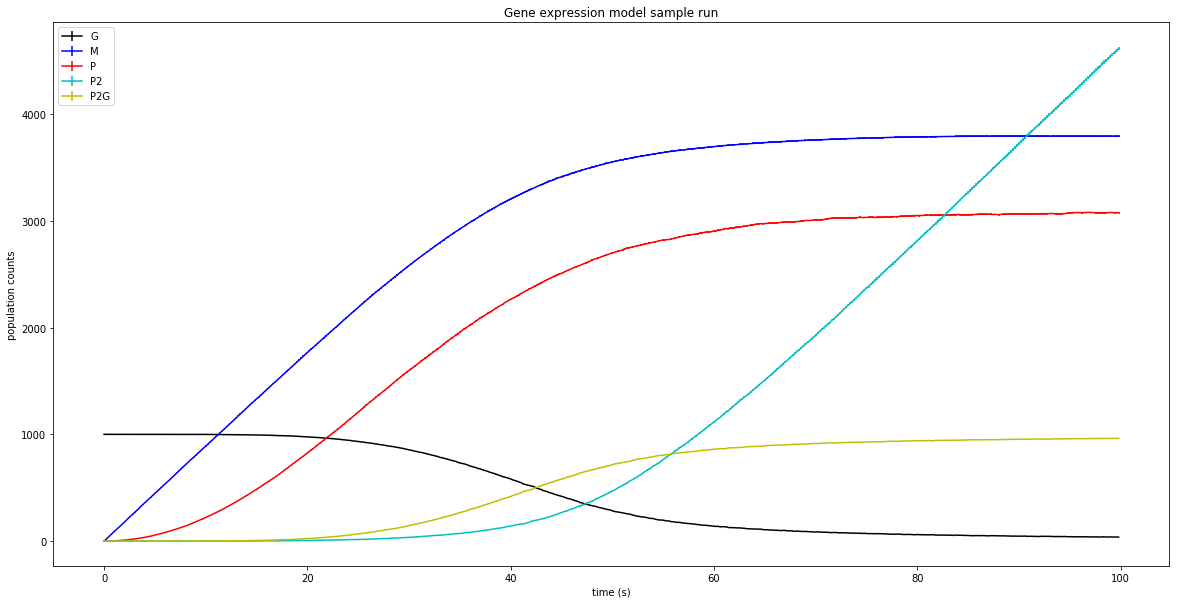

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("Gene expression model sample run")
(av, std) = simulate(solver_direct, t_final=100, n_replicas=50)
t = av[:,0]
plt.errorbar(t, av[:,1], yerr=std[:,1], label = 'G', color='k')
plt.errorbar(t, av[:,2], yerr=std[:,2], label = 'M', color='b')
plt.errorbar(t, av[:,3], yerr=std[:,3], label = 'P', color='r')
plt.errorbar(t, av[:,4], yerr=std[:,4], label = 'P2', color='c')
plt.errorbar(t, av[:,5], yerr=std[:,5], label = 'P2G', color='y')
plt.xlabel("time (s)")
plt.ylabel("population counts")
plt.legend()
plt.show()

## Benchmark

A comparison of the runtimes of the two stochastic solvers for this model.

In [10]:
def run_once(solver, n_G, vol, t_final=100):
    comp.setVol(vol)
    solver.reset()
    solver.setCompCount('comp', 'G', n_G)
    solver.setCompVol('comp', vol)
    solver.run(t_final)

def timing(solver, n_Gs = [10, 30, 100, 300, 1e3, 3e3, 1e4, 3e4, 1e5]):
    runtimes = []
    for n_G in n_Gs:
        reps = 3+int(5e4/n_G)
        timeit_output = %timeit -r $reps -n 1 -o run_once(solver, vol=vol, n_G=n_G);
        runtimes.append([n_G, timeit_output.best])
    return np.array(runtimes)

In [11]:
%%capture
runtime_rssa = timing(solver_rssa)
runtime_direct = timing(solver_direct)

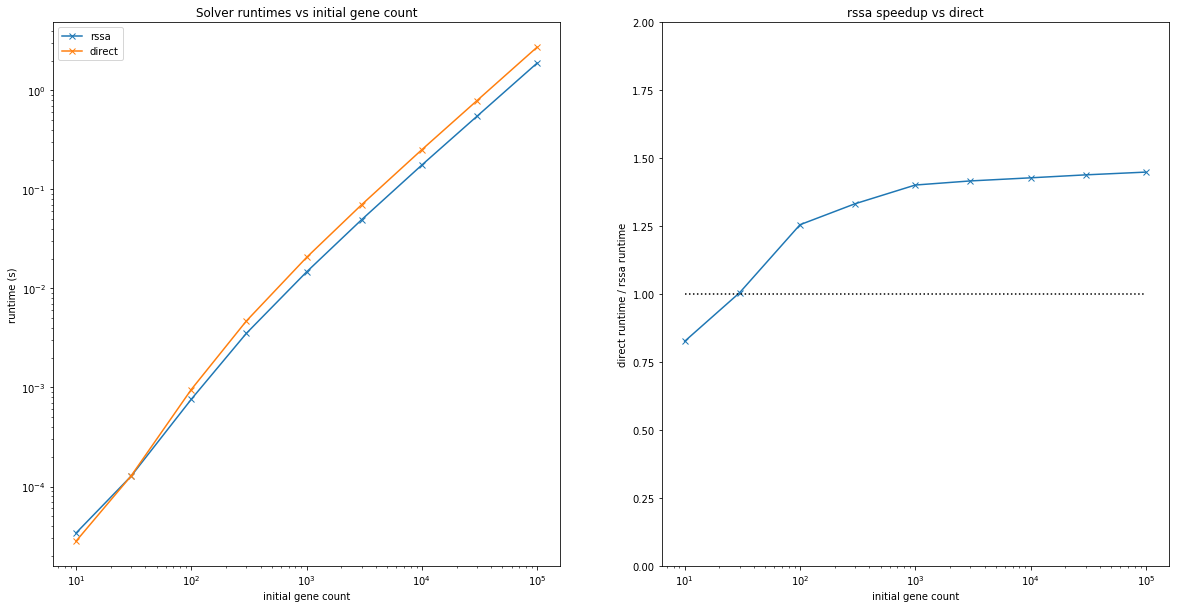

In [12]:
plt.subplot(1, 2, 1)
plt.title("Solver runtimes vs initial gene count")
plt.plot(runtime_rssa[:,0], runtime_rssa[:,1], label="rssa", marker="x", linestyle="-")
plt.plot(runtime_direct[:,0], runtime_direct[:,1], label="direct", marker="x", linestyle="-")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("runtime (s)")
plt.xlabel("initial gene count")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("rssa speedup vs direct")
plt.plot(runtime_rssa[:,0], runtime_direct[:,1]/runtime_rssa[:,1], marker="x", linestyle="-")
plt.plot(runtime_rssa[:,0], 1.0 + 0*runtime_rssa[:,0], marker="", color="k", linestyle=":")
plt.xscale("log")
plt.ylim([0, 2])
plt.ylabel("direct runtime / rssa runtime")
plt.xlabel("initial gene count")

plt.show()

## Comparison with analytic solution for simplified model

As a simple check of the solvers, we can set $c_5-c_8$ to zero and solve the remaining differential equations analytically to give:

\begin{align}
G(t) &= G_0 \\
M(t) &= \frac{G_0 c_1}{c_3} (1 - e^{-c_3 t}) \\
P(t) &= \frac{G_0 c_1 c_2}{c_3 c_4} \left(1 + \frac{c_3 e^{-c_4 t} - c_4 e^{-c_3 t}}{c_4 - c_3} \right) \\
P_2(t) &= 0 \\
P_2G(t) &= 0 \\
\end{align}

In [13]:
def analytic_G(t, G0=1000):
    return 0.0*t + G0

def analytic_M(t, G0=1000):
    c1 = kreac_1.getKcst()
    c3 = kreac_3.getKcst()
    return (G0 * c1 / c3) * (1.0 - np.exp(-c3 * t))

def analytic_P(t, G0=1000):
    c1 = kreac_1.getKcst()
    c2 = kreac_2.getKcst()
    c3 = kreac_3.getKcst()
    c4 = kreac_4.getKcst()
    ratio = 1.0 + (c3 * np.exp(-c4 * t) - c4 * np.exp(-c3 * t)) / (c4 - c3)
    return ratio * (G0 * c1 * c2) / (c3 * c4)

The three well-mixed solvers agree qualitatively with the analytic prediction:

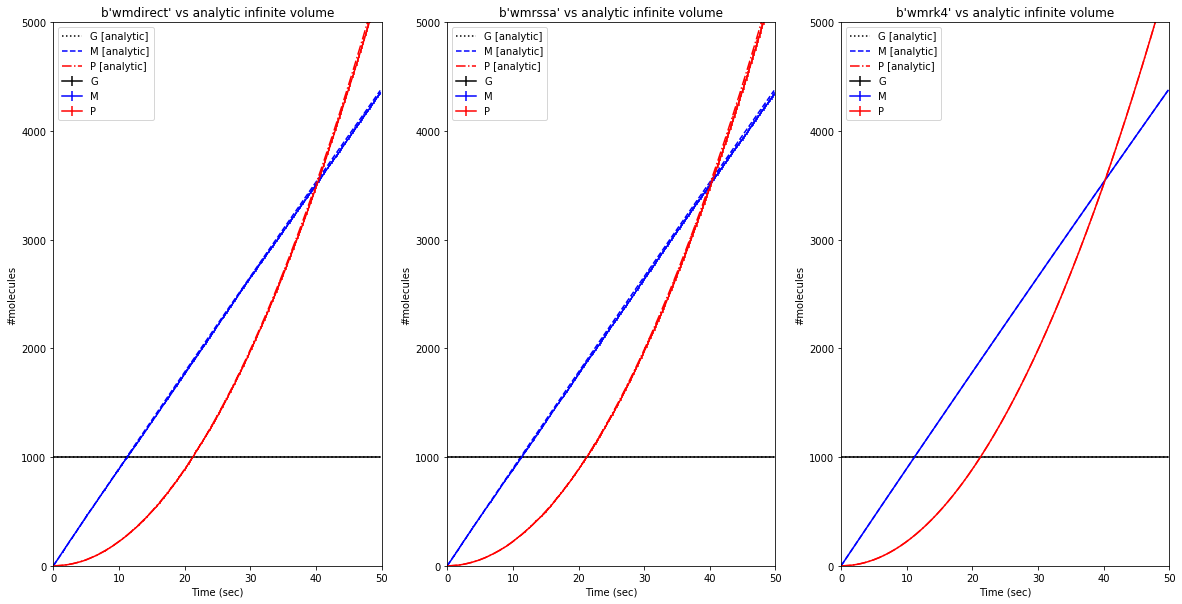

In [20]:
solver_rk4 = ssolver.Wmrk4(mdl, wmgeom)
solver_rk4.setRk4DT(1e-2)
solvers = [solver_direct, solver_rssa, solver_rk4]

for (i_solve, solver) in enumerate(solvers):
    plt.subplot(1, 3, i_solve+1)
    plt.title("%s vs analytic infinite volume" % solver.getSolverName())
    (av, std) = simulate(solver, n_replicas=20, simplified_model=True)
    t = av[:,0]
    plt.errorbar(t, av[:,1], yerr=std[:,1], label = 'G', color='k')
    plt.errorbar(t, av[:,2], yerr=std[:,2], label = 'M', color='b')
    plt.errorbar(t, av[:,3], yerr=std[:,3], label = 'P', color='r')
    plt.plot(t, analytic_G(t), label = 'G [analytic]', color='k', linestyle=':')
    plt.plot(t, analytic_M(t), label = 'M [analytic]', color='b', linestyle='--')
    plt.plot(t, analytic_P(t), label = 'P [analytic]', color='r', linestyle='-.')
    plt.xlim([0,50])
    plt.ylim([0,5000])
    plt.xlabel('Time (sec)')
    plt.ylabel('#molecules')
    plt.legend()
plt.show()

A quantitative comparison of the difference between the numerical results and the analytic predicion with errorbars for the stochastic solvers:

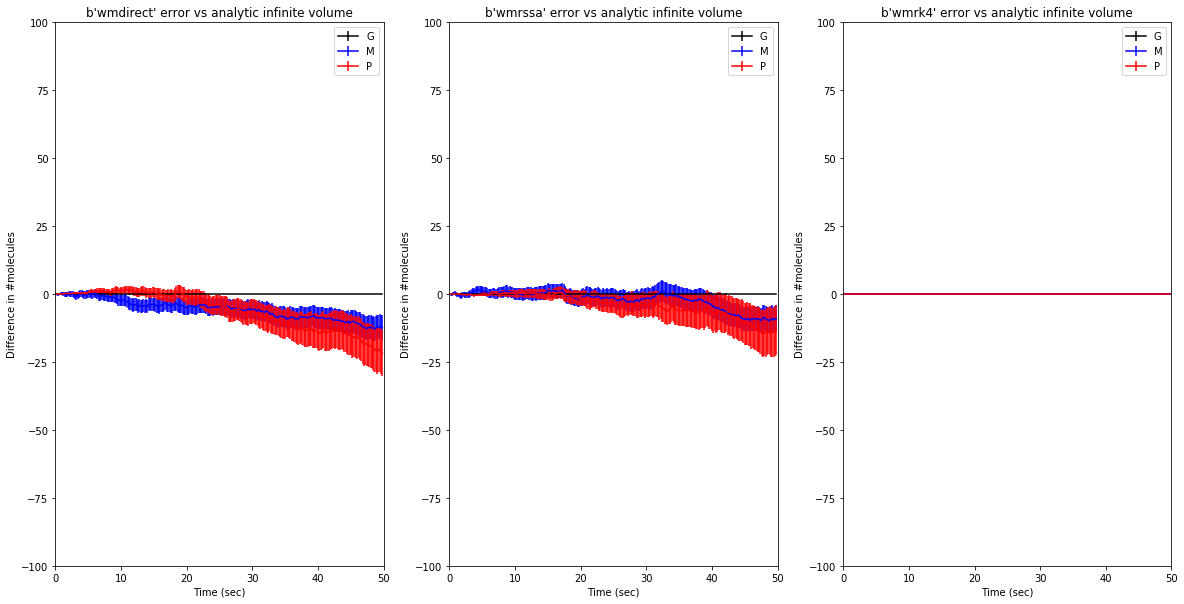

In [21]:
for (i_solve, solver) in enumerate(solvers):
    plt.subplot(1, 3, i_solve+1)
    plt.title("%s error vs analytic infinite volume" % solver.getSolverName())
    (av, std) = simulate(solver, n_replicas=200, simplified_model=True)
    t = av[:,0]
    plt.errorbar(t, av[:,1]-analytic_G(t), yerr=std[:,1], label = 'G', color='k')
    plt.errorbar(t, av[:,2]-analytic_M(t), yerr=std[:,2], label = 'M', color='b')
    plt.errorbar(t, av[:,3]-analytic_P(t), yerr=std[:,3], label = 'P', color='r')
    plt.xlim([0,50])
    plt.ylim([-100,100])
    plt.xlabel('Time (sec)')
    plt.ylabel('Difference in #molecules')
    plt.legend()
plt.show()